In [1]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
# from unet import AttUNet, UNet, UNetWithPretrainedEncoder
# from dataloader import ImageDataset, TransformWrapper
import os
import random
from random import shuffle
import numpy as np
import torch
from torch.utils import data
from torchvision import transforms as T
import torchvision.transforms.functional as F

from PIL import Image
from PIL.ImageFile import ImageFile

from pathlib import Path

from PIL import Image
import numpy as np
import cv2

def apply_clahe(pil_img):
    # Convert PIL image to NumPy array
    img = np.array(pil_img)

    # If grayscale
    if len(img.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img)
    # If RGB
    elif len(img.shape) == 3:
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)
        img_lab_clahe = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError("Unsupported image format")

    # Convert back to PIL image
    return Image.fromarray(img_clahe)


class TransformWrapper:

    def __init__(self):
        self.image_transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=[30, 60, 90, 120, 150]),
            T.ToTensor(),
        ])

        self.mask_transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=45),
            T.ToTensor(),
        ])

    def __call__(self, image, mask):
        # Apply the same random seed to ensure consistent transformations
        seed = torch.randint(0, 2**32, (1, )).item()
        torch.manual_seed(seed)
        image = self.image_transforms(image)

        torch.manual_seed(seed)
        mask = self.mask_transforms(mask)

        return image, mask


class ImageDataset(data.Dataset):

    def __init__(self,
                 images: list[ImageFile],
                 masks: list[ImageFile],
                 transform: bool = False,
                 image_size: int = 224):

        self.images = images
        self.masks = masks
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,
                    index) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        image = self.images[index]
        mask = self.masks[index]

        image = image.resize((self.image_size, self.image_size),
                             Image.Resampling.LANCZOS)
        mask = mask.resize((self.image_size, self.image_size),
                           Image.Resampling.LANCZOS)

        image = apply_clahe(image)
        image = T.GaussianBlur(3)(image)

        mask = mask.convert("L")  # Ensure mask is in grayscale
        binary_threshold = 100  # Adjust this threshold as needed
        mask = mask.point(lambda p: 255 if p > binary_threshold else 0)
        mask = mask.convert('1')
        

        normalize_tensor = T.Compose([
            T.Lambda(lambda x: x.convert("RGB")),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            T.Lambda(lambda x: x),
        ])

        if self.transform:
            angle = random.uniform(-90, 90)
            
            image = F.rotate(image, angle)
            image = normalize_tensor(image)
            mask = T.ToTensor()(F.rotate(mask, angle))
            return image, mask

        return normalize_tensor(image), T.ToTensor()(mask)

data_pth = Path(
    '/Users/tsakalis/Downloads/ECImageAnalysisMouse/New Binary Masks')
blastocyst_pth = Path('/home/tsakalis/ntua/phd/cellforge/cellforge/data')

full_path = "/Users/tsakalis/ntua/cellforge/data/D2016.07.08_S1366_I149_11"

blastocyst_images_pth = blastocyst_pth / 'annotation_pn/images_pn'
blastocyst_msk_pth = blastocyst_pth / 'annotation_pn/masks_pn'

smooth = 1e-15

device = 'cuda'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [2]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.png')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)


In [3]:
import numpy as np
from PIL import Image
from scipy.ndimage import center_of_mass


def crop_around_center(image: Image.Image, mask: Image.Image,
                       crop_size: int) -> Image.Image:
    """
    Finds the center of mass of the non-zero pixels in the image
    and crops the image around that point.

    Args:
        image (PIL.Image.Image): Input image (grayscale or binary recommended).
        crop_size (int): Size of the square crop (e.g., 128 for 128x128 crop).

    Returns:
        PIL.Image.Image: Cropped image around the center of mass.
    """
    # Convert image to grayscale and NumPy array
    image_array = np.array(image.convert("L"))

    # Find the center of mass of non-zero pixels
    com = center_of_mass(image_array)

    # Round to integers for pixel indexing
    center_y, center_x = map(int, com)

    # Calculate crop box
    half_crop = crop_size // 2
    left = max(center_x - half_crop, 0)
    upper = max(center_y - half_crop, 0)
    right = min(center_x + half_crop, image.width)
    lower = min(center_y + half_crop, image.height)

    # Crop the image
    cropped_image = image.crop((left, upper, right, lower))

    cropped_mask = mask.crop((left, upper, right, lower))
    return cropped_image, cropped_mask


# Example usage


In [2]:
image_file_paths = sorted(list(blastocyst_images_pth.glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list(blastocyst_msk_pth.glob('*.png')),
                         key=lambda x: x.stem)


In [3]:
blastocyst_images_pth


PosixPath('/home/tsakalis/ntua/phd/cellforge/cellforge/data/annotation_pn/images_pn')

In [4]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)

# print("... Loading images ...")
images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]

c = list(zip(images, masks))
import random

random.shuffle(c)

images, masks = zip(*c)

# def remove_alpha(img):
#     if img.mode == 'RGBA':  # If image has an alpha channel
#         background = Image.new('RGB', img.size,
#                                (255, 255, 255))  # Create white background
#         background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
#         return background
#     return img  # Return unchanged if no alpha channel

# # Process images and masks
# images = [remove_alpha(img) for img in tqdm(images)]
# masks = [remove_alpha(msk) for msk in tqdm(masks)]

# cropped_images = []
# cropped_masks = []
# for image, mask in zip(images, masks):

#     cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

#     cropped_images.append(cropped)
#     cropped_masks.append(cropped_mask)

train_dataset = ImageDataset(images=images[:400],
                             masks=masks[:400],
                             transform=True)
val_dataset = ImageDataset(images=images[400:800], masks=masks[400:800])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=32)


0it [00:00, ?it/s]
0it [00:00, ?it/s]


ValueError: not enough values to unpack (expected 2, got 0)

In [21]:
len(train_dataloader)

NameError: name 'train_dataloader' is not defined

In [7]:
import random
from torchvision import transforms as T
import torchvision.transforms.functional as F

In [23]:
for im, gt in train_dataloader:
    break

NameError: name 'train_dataloader' is not defined

In [5]:
import segmentation_models_pytorch as smp

model = smp.Unet(
        encoder_name="resnet152",
        encoder_weights="imagenet",
        in_channels=3,
        classes=2,
    )
model.to(device)
lr = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 100

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [8]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

/tmp/ipykernel_2825871/3522360610.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [27]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:
        img_batch = img_batch.to(device)
        gt_msk_batch = gt_msk_batch.to(device)

        optimizer.zero_grad()
        with autocast():
            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )


NameError: name 'train_dataloader' is not defined

In [28]:
import matplotlib.pyplot as plt
plt.imshow(img_batch[10,0,:].cpu().numpy())

NameError: name 'img_batch' is not defined

In [17]:
import torch


def compute_iou_and_dice(pred: torch.Tensor,
                         gt: torch.Tensor) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Compute intersection and union
    intersection = torch.sum(pred * gt)
    union = torch.sum(pred) + torch.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (torch.sum(pred) + torch.sum(gt))).item() if (
        torch.sum(pred) + torch.sum(gt)) > 0 else 0.0

    return iou, dice


# # Example usage
# pred_mask = torch.randint(0, 2, (256, 256),
#                           dtype=torch.float32)  # Example predicted mask
# gt_mask = torch.randint(0, 2, (256, 256),
#                         dtype=torch.float32)  # Example ground truth mask

iou_fn, dice_fn = compute_iou_and_dice(torch.sigmoid(pred_mask),
                                       gt_msk_batch.to(device))
print(f"IoU: {iou_fn:.4f}, Dice: {dice_fn:.4f}")


NameError: name 'pred_mask' is not defined

In [30]:
torch.save(model.state_dict(), "/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/big_good_pn_model.pt")


In [6]:
model = smp.Unet(
        encoder_name="resnext101_32x48d",#"resnext101_32x48d",
        encoder_weights="instagram",
        in_channels=3,
        classes=3,
    )

In [7]:
model.load_state_dict(torch.load("/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/pronuclei_seperate_xl.pt", weights_only=True))
model.eval()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [8]:
from torchsummary import summary
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 224, 224]         --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         1,178,624
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         1,456,640
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         1,456,640
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         5,158,912
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         5,813,248
|    |    └─Bottleneck: 3-6              [-1, 

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 224, 224]         --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         1,178,624
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         1,456,640
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         1,456,640
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         5,158,912
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         5,813,248
|    |    └─Bottleneck: 3-6              [-1, 

In [9]:
model.eval()
gt_masks_all = []
pred_masks_all = []

all_images = []


for img_batch, gt_msk_batch in val_dataloader:

    with autocast():
        pred_mask = model(img_batch.to(device))
    all_images.append(img_batch)
    pred_masks_all.append(pred_mask.to('cpu'))
    gt_masks_all.append(gt_msk_batch.to('cpu'))


NameError: name 'val_dataloader' is not defined

In [ ]:
from torchmetrics import JaccardIndex, Dice


In [ ]:
iou_fn = JaccardIndex(task='binary', threshold=0.90)
dice_fn = Dice(threshold=0.90)

iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all))

dice_fn(
    torch.sigmoid(torch.vstack(pred_masks_all)),
    torch.vstack(gt_masks_all).long(),
)

print(
    f"IoU: {iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all)):.3f}"
)

print(
    f"Dice Coeff: {dice_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all).long()):.3f}"
)

sample_pred_mask = torch.sigmoid(pred_masks_all[0][3][0].detach())

sample_gt_mask = gt_masks_all[0][3][0].detach()

RuntimeError: vstack expects a non-empty TensorList

In [14]:

from PIL import Image
import numpy as np
from skimage.morphology import binary_dilation
slide_id = 'D2016.10.18_S1418_I149_6'
sample_path = Path(
    "/home/tsakalis/ntua/phd/cellforge/cellforge/data/")
def inference_whole_slide(model,slide_pth: Path, max_frame: int):
    

    image_file_paths = sorted(list(slide_pth.glob('*.jpg')),
                            key=lambda x: int(x.stem))[:max_frame]

    images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

    val_dataset = ImageDataset(images=images, masks=images)

    val_dataloader = DataLoader(val_dataset, batch_size=32)


    model.eval()
    from torch.cuda.amp import autocast

    all_masks = []
    for inpt_images, _ in val_dataloader:
        with torch.no_grad():
            with autocast():
                pred_mask = model(inpt_images.to(device))
                masks = torch.sigmoid(pred_mask).cpu().numpy()>0.00001
                all_masks.extend([msk for msk in masks])
    

    pn_size = []
    final_images = []
    upscaled_masks = []
    isolated_pns = []
    for pil_img, mask in zip(images[:], all_masks[:]):
        # Ensure the mask is 2D by removing extra dimensions
        # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
        image_ar = np.stack(3*[np.array(pil_img)])
        
        upscaled_mask1 = cv2.resize(mask[1].astype(np.uint8), (500,500), interpolation=cv2.INTER_NEAREST)
        upscaled_mask2 = cv2.resize(mask[2].astype(np.uint8), (500,500), interpolation=cv2.INTER_NEAREST)
        # pn_size.append(upscaled_mask.sum())
    

        upscaled_masks.append((upscaled_mask1, upscaled_mask2))
        image_pn_isolated = image_ar.copy()
        image_pn_isolated[:,~upscaled_mask1.astype(bool)] = 0
        isolated_pns.append(image_pn_isolated.transpose(1,2,0))
        image_ar[0,upscaled_mask1.astype(bool)] = 240
        image_ar[1,upscaled_mask2.astype(bool)] = 240


        final_images.append(Image.fromarray(image_ar.transpose(1,2,0)))

    return final_images, upscaled_masks, 

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from contextlib import contextmanager

@contextmanager
def video_writer_context(output_path, frame_height, frame_width, fps=5):
    # Create a dummy figure to get graph size
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1])
    fig.canvas.draw()
    graph_h, graph_w = fig.canvas.get_width_height()
    plt.close(fig)

    scale = frame_height / graph_h
    graph_resized_width = int(graph_w * scale)
    output_size = (frame_width + graph_resized_width, frame_height)

    output = cv2.VideoWriter(
        str(output_path),
        cv2.VideoWriter_fourcc(*'XVID'),
        fps,
        output_size
    )

    try:
        yield output, graph_resized_width
    finally:
        output.release()
        cv2.destroyAllWindows()

def generate_video(slide_images, slide_masks, output_path, frame_height=500, frame_width=500):
    pn_size1 = []
    pn_size2 = []

    with video_writer_context(output_path, frame_height, frame_width) as (output, graph_resized_width):
        for frame_idx, frame in enumerate(slide_images):

            if len(slide_masks[frame_idx])==2:

                pn_size1.append(slide_masks[frame_idx][0].sum())
                pn_size2.append(slide_masks[frame_idx][1].sum())

            x = np.arange(start=0, stop=frame_idx + 1, step=1)

            fig, ax = plt.subplots()
            ax.plot(x, pn_size1)
            ax.plot(x, pn_size2)
            ax.set_title(f"Accumulated PN Size (Frame {frame_idx})")
            ax.set_xlabel('Frame')
            ax.set_ylabel('Accumulated Area')
            fig.tight_layout()
            fig.canvas.draw()

            plot_img = np.asarray(fig.canvas.buffer_rgba())[:, :, :3]
            plt.close(fig)

            plot_resized = cv2.resize(plot_img, (graph_resized_width, frame_height))
            plot_bgr = cv2.cvtColor(plot_resized, cv2.COLOR_RGB2BGR)

            combined = np.hstack((np.array(frame), plot_bgr))

            output.write(combined)
            cv2.imshow("output", combined)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break


In [10]:
# def create_video(slide_images, slide_masks, sample_idx):


In [ ]:
import enum
from pathlib import Path
from random import shuffle
from typing import Callable, Literal
import torch
import numpy as np
import torch.nn as nn
from torch.cuda.amp import autocast
from torch.utils import data
from torch.utils.data import DataLoader, Dataset, dataloader
from torchvision import models
from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from segmentation_utils.dataloader import ImageDataset
from PIL import Image

from enum import StrEnum

def create_all_masks_separate(whole_embryo_segmentation_model: nn.Module):
    """
    This function will take the pronuclei masks and create the other 2 classes.

    We will need some extra samples to be used as counter examples
    (when pronuclei are not showing).

    """
    DEVICE = "cuda"
    BATCH_SIZE = 32
    MASK_THRESHOLD = 0.9
    IMAGE_SIZE = 224

    base_cicle_pth = Path("/media/tsakalis/STORAGE/phd/pronuclei_tracking")
    timelapse_pth = Path(
        "/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses"
    )

    all_circle_data = list((base_cicle_pth / "fitted_circles_samples").glob("*.json"))
    import json

    images = []
    masks = []
    for circle_file_pth in tqdm(all_circle_data):
        slide_id = str(circle_file_pth).split("/")[-1][:-5]
        with open(circle_file_pth) as f:
            circles = json.load(f)

        for circle in circles:
            full_frame_pth = timelapse_pth / f"{slide_id}/{circle['frame']}_0.jpg"
            frame_img = Image.open(full_frame_pth)
            mask = np.zeros((500, 500, 3), dtype=np.uint8)

            y_grid, x_grid = np.ogrid[:500, :500]

            # Full blob for pn1 on channel 0
            center1 = (int(circle["pn1"]["x"]), int(circle["pn1"]["y"]))
            radius1 = int(circle["pn1"]["r"])
            blob1 = (x_grid - center1[0]) ** 2 + (
                y_grid - center1[1]
            ) ** 2 <= radius1**2
            mask[..., 1][blob1] = 255

            # Full blob for pn2 on channel 1, if available
            if circle["pn2"]:
                center2 = (int(circle["pn2"]["x"]), int(circle["pn2"]["y"]))
                radius2 = int(circle["pn2"]["r"])
                blob2 = (x_grid - center2[0]) ** 2 + (
                    y_grid - center2[1]
                ) ** 2 <= radius2**2
                mask[..., 2][blob2] = 255

            mask_image = Image.fromarray(mask)
            images.append(frame_img)
            masks.append(mask_image)

    dataset = ImageDataset(images=images, masks=masks, transform=False)

    dataloader = DataLoader(dataset=dataset, shuffle=False, batch_size=BATCH_SIZE)

    whole_embryo_segmentation_model.eval()
    whole_embryo_segmentation_model.to(DEVICE)

    complete_masks = []
    for batch_im, batch_mask in tqdm(dataloader):

        batch_im = batch_im.to(DEVICE)
        with torch.no_grad():
            pred_masks = (
            torch.sigmoid(
                inference(
                    whole_embryo_segmentation_model,
                    batch_im,
                    precision=InferencePrecision.MIXED,
                )
            )
            > 0.00
        )
        
        pred_masks = pred_masks.cpu().numpy()

        for prd_msk, msk in zip(pred_masks, batch_mask.cpu().numpy()):
            # breakpoint()

            msk*=255

            msk[0,...] = prd_msk.astype(int)*255

            

            complete_masks.append(Image.fromarray(msk.astype(np.uint8).transpose(1,2,0)))
            # breakpoint()/
            # break
            # breakpoint()

    
    final_images = []
    final_masks = []

    for im, msk in zip(images, complete_masks):
        
        msk_ar = np.array(msk)[:,:,0]
        
        if msk_ar.sum()<590190:
            continue

        final_images.append(im)
        final_masks.append(msk)
        

        

    return final_images, final_masks


class InferencePrecision(StrEnum):
    FULL = "full"
    HALF = "half"
    MIXED = "mixed"



def inference(model, X, precision: InferencePrecision = InferencePrecision.FULL, *args):

    match precision:
        case InferencePrecision.MIXED:
            with autocast():
                return model(X, *args)

        case InferencePrecision.FULL:
            with torch.no_grad():
                return model(X, *args)

    return model(X, *args)

In [110]:
images, masks = create_all_masks_separate(model)

  0%|          | 0/359 [00:00<?, ?it/s]/tmp/ipykernel_3489970/1763680585.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 359/359 [00:47<00:00,  7.57it/s]


In [108]:
np.array(masks[9800])[:,:,0].sum()

1994355

In [114]:
np.array(masks[9500])[:,:,0].sum()

290190

In [32]:
create_all_masks_separate

<function __main__.create_all_masks_separate()>

In [12]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [55]:
sample_ids = [
            'D2016.07.08_S1366_I149_11',
            'D2016.10.18_S1418_I149_6',
            'D2016.10.18_S1418_I149_8',
            'D2016.10.18_S1418_I149_11'
            ]

all_pn_areas = []
for sample_idx, sample_id in enumerate(sample_ids):

    slide_images, slide_masks = inference_whole_slide(model, sample_path/sample_id, 200)
    all_pn_areas.append(pn_area)

    plt.plot(pn_area)
    # output_path = Path(f"/home/tsakalis/pn_samples/accumulated_pn_area_sample_whole{sample_idx}_multilabel.mp4")
    # generate_video(slide_images, slide_masks, output_path)

    

100%|██████████| 200/200 [00:00<00:00, 39907.75it/s]
/tmp/ipykernel_2797987/3980970269.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


NameError: name 'pn_area' is not defined

In [ ]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [20]:
model_weights = Path("/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights")

# if __name__ == "__main__":/

import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet152",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

# model_pronuclei = smp.Unet(
#     encoder_name="resnext101_32x48d",  # "resnext101_32x48d",
#     encoder_weights="instagram",
#     in_channels=3,
#     classes=3,
# )

model.load_state_dict(
    torch.load(model_weights / "inner_embryo.pt", weights_only=True)
)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:

def create_all_masks_separate(whole_embryo_segmentation_model: nn.Module):
    """
    This function will take the pronuclei masks and create the other 2 classes.

    We will need some extra samples to be used as counter examples
    (when pronuclei are not showing).

    """
    DEVICE = "cuda"
    BATCH_SIZE = 32
    MASK_THRESHOLD = 0.9
    IMAGE_SIZE = 224

    base_cicle_pth = Path("/media/tsakalis/STORAGE/phd/pronuclei_tracking")
    timelapse_pth = Path(
        "/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses"
    )

    all_circle_data = list((base_cicle_pth / "fitted_circles_samples").glob("*.json"))
    import json

    images = []
    masks = []
    for circle_file_pth in tqdm(all_circle_data):
        slide_id = str(circle_file_pth).split("/")[-1][:-5]
        with open(circle_file_pth) as f:
            circles = json.load(f)

        for circle in circles:
            full_frame_pth = timelapse_pth / f"{slide_id}/{circle['frame']}_0.jpg"
            frame_img = Image.open(full_frame_pth)
            mask = np.zeros((500, 500, 3), dtype=np.uint8)

            y_grid, x_grid = np.ogrid[:500, :500]

            # Full blob for pn1 on channel 0
            center1 = (int(circle["pn1"]["x"]), int(circle["pn1"]["y"]))
            radius1 = int(circle["pn1"]["r"])
            blob1 = (x_grid - center1[0]) ** 2 + (
                y_grid - center1[1]
            ) ** 2 <= radius1**2
            mask[..., 1][blob1] = 255

            # Full blob for pn2 on channel 1, if available
            if circle["pn2"]:
                center2 = (int(circle["pn2"]["x"]), int(circle["pn2"]["y"]))
                radius2 = int(circle["pn2"]["r"])
                blob2 = (x_grid - center2[0]) ** 2 + (
                    y_grid - center2[1]
                ) ** 2 <= radius2**2
                mask[..., 2][blob2] = 255

            mask_image = Image.fromarray(mask)
            images.append(frame_img)
            masks.append(mask_image)

    dataset = ImageDataset(images=images, masks=masks, transform=False)

    dataloader = DataLoader(dataset=dataset, shuffle=False, batch_size=BATCH_SIZE)

    whole_embryo_segmentation_model.eval()
    whole_embryo_segmentation_model.to(DEVICE)

    complete_masks = []
    for batch_im, batch_mask in tqdm(dataloader):

        batch_im = batch_im.to(DEVICE)
        with torch.no_grad():
            pred_masks = (
            torch.sigmoid(
                inference(
                    whole_embryo_segmentation_model,
                    batch_im,
                    precision=InferencePrecision.MIXED,
                )
            )
            > 0.7
        )
        
        pred_masks = pred_masks.cpu().numpy()

        for prd_msk, msk in zip(pred_masks, batch_mask.cpu().numpy()):
            
            # breakpoint()

            msk*=255

            msk[0,...] = prd_msk.astype(int)*255

            

            complete_masks.append(Image.fromarray(msk.astype(np.uint8).transpose(1,2,0)))
            # breakpoint()/
            # breakpoint()

            
        

    return images, complete_masks


In [16]:
import matplotlib.pyplot as plt

100%|██████████| 200/200 [00:00<00:00, 39730.07it/s]
/tmp/ipykernel_3489970/3411951409.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


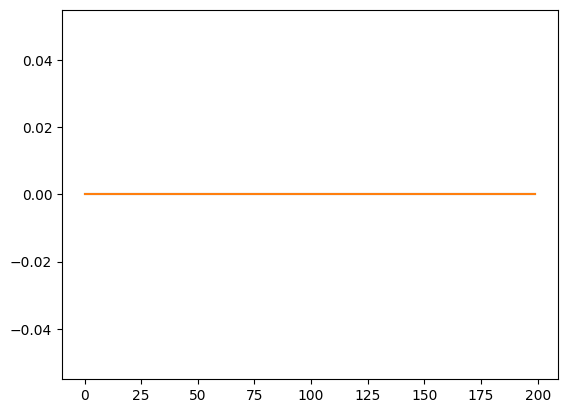

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 200/200 [00:00<00:00, 682.35it/s]


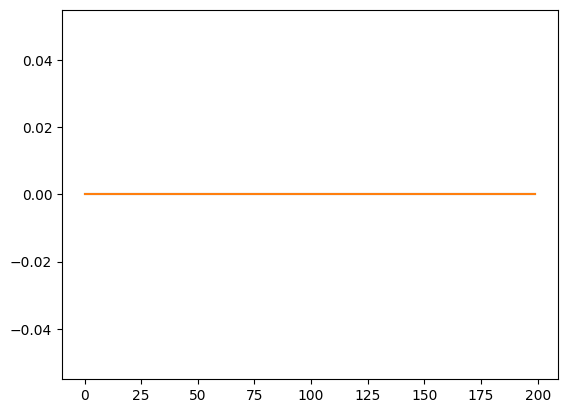

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 200/200 [00:00<00:00, 37032.53it/s]


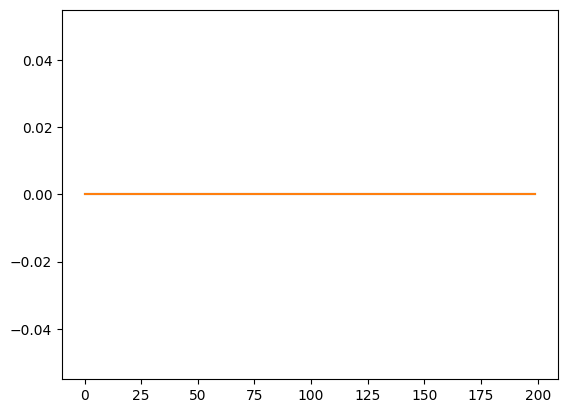

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 200/200 [00:00<00:00, 43202.39it/s]


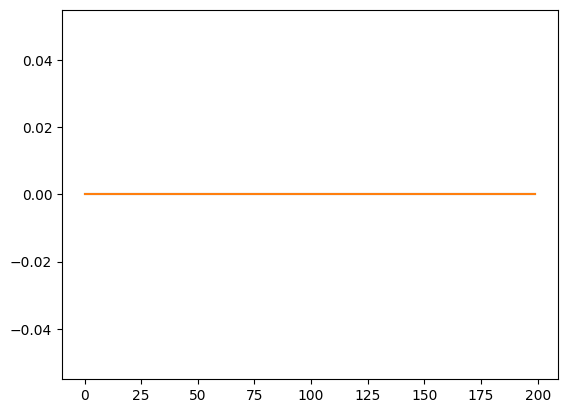

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [19]:
sample_ids = [
            'D2016.07.08_S1366_I149_11',
            'D2016.10.18_S1418_I149_6',
            'D2016.10.18_S1418_I149_8',
            'D2016.10.18_S1418_I149_11'
            ]

all_pn_areas = []
for sample_idx, sample_id in enumerate(sample_ids):

    slide_images, slide_masks = inference_whole_slide(model, sample_path/sample_id, 200)
    # break
    plt.plot(np.array([(a.sum(), b.sum()) for a, b in slide_masks]))
    plt.show()

    # plt.plot(pn_area)
    output_path = Path(f"/home/tsakalis/pn_samples/seperate_pn_{sample_idx}_multilabel.mp4")
    generate_video(slide_images, slide_masks, output_path)

    

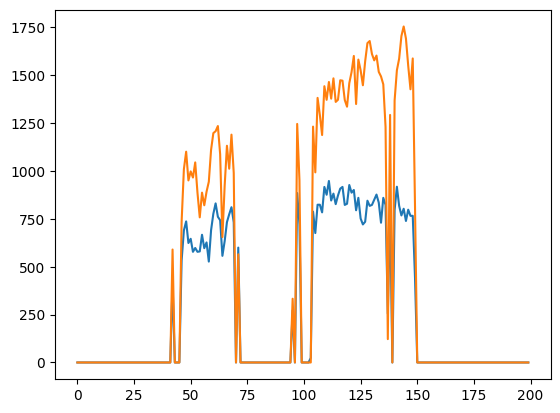

In [ ]:
slide_masks[0].shape

(500, 500)

In [60]:
for pn_area in all_pn_areas:
    plt.plot(np.gradient(pn_area))

In [ ]:
sample_path = Path(
    "/home/tsakalis/ntua/phd/cellforge/cellforge/data/D2016.10.18_S1418_I149_6")

image_file_paths = sorted(list(sample_path.glob('*.jpg')),
                          key=lambda x: int(x.stem))

images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

# def remove_alpha(img):
#     if img.mode == 'RGBA':  # If image has an alpha channel
#         background = Image.new('RGB', img.size,
#                                (255, 255, 255))  # Create white background
#         background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
#         return background
#     return img  # Return unchanged if no alpha channel

# # Process images and masks
# images = [remove_alpha(img) for img in tqdm(images)]
# masks = [remove_alpha(msk) for msk in tqdm(masks)]

# cropped_images = []
# cropped_masks = []
# for image, mask in zip(images, masks):

#     cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

#     cropped_images.append(cropped)
#     cropped_masks.append(cropped_mask)



100%|██████████| 560/560 [00:00<00:00, 40858.11it/s]


100%|██████████| 150/150 [00:00<00:00, 34734.48it/s]
/tmp/ipykernel_2072954/2015305102.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


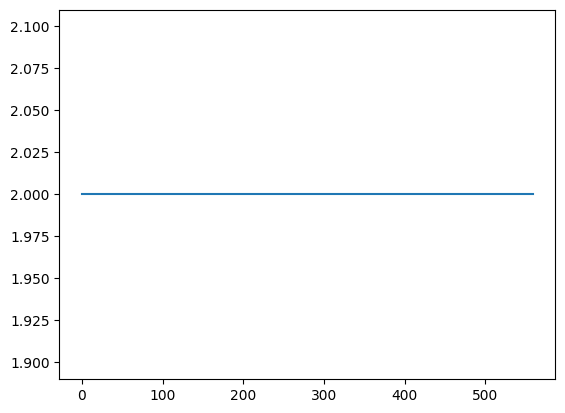

In [ ]:
plt.plot(pn_size)

In [ ]:
def dice_coef_np(y_pred, y_true):

    intersection = np.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        np.sum(y_true).flatten() + np.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [ ]:
def compute_iou_and_dice_np(pred, gt) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).astype(float)
    gt = (gt > 0.5).astype(float)

    # Compute intersection and union
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (np.sum(pred) + np.sum(gt))).item() if (
        np.sum(pred) + np.sum(gt)) > 0 else 0.0

    return iou, dice

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load mask
c = masks[44][0].astype(np.uint8)
_, binary = _, mask

H, W = binary.shape

# Helper to draw a single circle mask
def draw_circle(h, w, x, y, r):
    Y, X = np.ogrid[:h, :w]
    return ((X - x)**2 + (Y - y)**2) <= r**2

# Loss function: overlap mismatch between union of circles and the binary mask
def loss_fn(params):
    x1, y1, r1, x2, y2, r2 = params
    circle1 = draw_circle(H, W, x1, y1, r1)
    circle2 = draw_circle(H, W, x2, y2, r2)
    union = np.logical_or(circle1, circle2).astype(np.uint8)
    iou, dice = compute_iou_and_dice_np(union,binary)
    return -iou#dice_coef_np(union, binary)
    

# Initial guess: center of image and equal radii
initial_guess = [W//3, H//2, 100, 2*W//3, H//2, 1]

# Bounds to constrain solution
bounds = [
    (0, W), (0, H), (5, W//2),
    (0, W), (0, H), (5, W//2),
]

# Run optimization
result = minimize(loss_fn, initial_guess, bounds=bounds, method='L-BFGS-B')
x1, y1, r1, x2, y2, r2 = result.x

circle1 = draw_circle(H, W, x1, y1, r1)
circle2 = draw_circle(H, W, x2, y2, r2)
union = np.logical_or(circle1, circle2).astype(np.uint8)
# Visualize
result_mask = np.zeros((H, W), dtype=np.uint8)
cv2.circle(result_mask, (int(x1), int(y1)), int(r1), 1, -1)
cv2.circle(result_mask, (int(x2), int(y2)), int(r2), 1, -1)
result_mask *= 255

overlay = cv2.merge([binary * 255, result_mask, np.zeros_like(result_mask)])

plt.imshow(overlay)
plt.title("Green: Fitted Circles | Red: Original Mask")
plt.axis("off")
plt.show()


IndexError: index 44 is out of bounds for axis 0 with size 40

In [ ]:
from skimage.color import rgb2gray



In [ ]:
rgb2gray(isolated_pns[44])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
label_im

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


image = upscaled_masks[44]

label_img = label(image)
regions = regionprops(label_img)

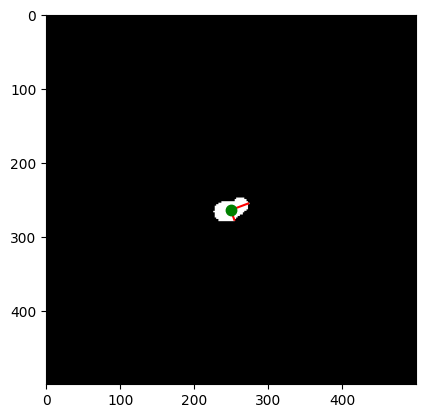

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    # ax.plot(bx, by, '-b', linewidth=2.5)


plt.show()

In [ ]:
props = regionprops_table(
    label_img,
    properties=None

)

TypeError: 'NoneType' object is not iterable

In [ ]:
props


{'centroid-0': array([263.81139122]),
 'centroid-1': array([249.22875817]),
 'orientation': array([-1.21167299]),
 'axis_major_length': array([50.30582695]),
 'axis_minor_length': array([27.92539493])}

In [ ]:
import sys
import matplotlib
matplotlib.use('TkAgg')

In [ ]:
sample_pred_mask = mask[0]
sample_gt_image = image_ar[0]

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'source_image', 'sample_gt_mask', and 'sample_pred_mask' are numpy arrays
# Display side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original ground truth mask
axes[0].imshow(sample_gt_mask.numpy(), cmap='gray')
axes[0].set_title("Ground Truth Mask")
axes[0].axis('off')

# Prediction mask thresholded
axes[1].imshow(mask[0] > 0.4, cmap='gray')
axes[1].set_title("Predicted Mask > 0.4")
axes[1].axis('off')

# Overlay source image with ground truth and predicted masks
overlay_image = all_images[0][3][0].numpy().copy()
# Adjust overlay to include masks for better visibility

axes[2].imshow(overlay_image, cmap='gray')
axes[2].set_title("Overlay with Source Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()


TypeError: Invalid shape (224,) for image data